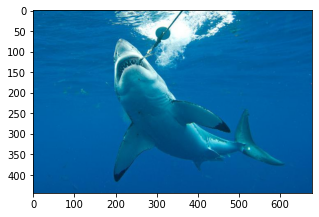

In [23]:
import torchvision 
from torchvision import transforms
import torch 
import matplotlib.pyplot as plt
import json 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import sys 
sys.path.append("../")

with open("../data/imagenet_label.json", "rb") as f:
    labels = json.load(f)

testset = torchvision.datasets.ImageNet(root="/data3/bumjin_data/ILSVRC2012_val", split='val')
model = torchvision.models.vgg16(pretrained=True)
model.cuda()
model.eval()

plt.figure(figsize=(5,5), facecolor="white")
plt.imshow(testset[100][0])

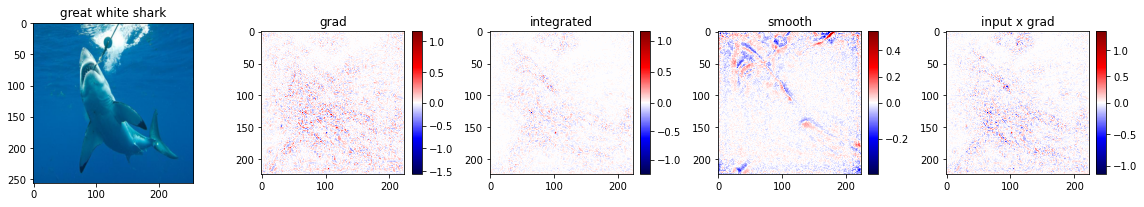

In [19]:
preprocess = transforms.Compose([
                            # transforms.ToPILImage(),
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    
                        ])

from src.input_gradient import InputGradient
vg = InputGradient(model, method="vanilla", device="cuda")
ig = InputGradient(model, method="ig", device="cuda")
sg = InputGradient(model, method="smooth", device="cuda")
itg = InputGradient(model, method="input_times_grad", device="cuda")

# 100 / 10503 / 12425
index =100
origianl_image = testset[index][0]
x = preprocess(origianl_image).cuda()

fig , axes = plt.subplots(1,5, figsize=(16, 4), facecolor="white")
for i in range(4):
    method = [vg, ig, sg, itg][i]
    args = [{},  # vanilla gradient
            {"M":100, "baseline":torch.zeros_like(x)},  # integrated gradient 
            {"M":100, "sigma":2},                       # smooth gradient   
            {}][i]                                      # input x gradient
    output = method.forward(x, **args)

    Attr = output['attr'].detach().cpu()
    attr = Attr.sum(0)
    
    ax = axes[i+1]
    divnorm=colors.TwoSlopeNorm(vmin=attr.min(), vcenter=0., vmax=attr.max())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='7%', pad="5%")
    im = ax.imshow(attr, cmap="seismic", norm=divnorm )
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(['grad', 'integrated', 'smooth', 'input x grad'][i])
ax = axes[0]
ax.imshow(origianl_image.resize((256, 256)))
ax.set_title(labels[testset[index][1]])
plt.tight_layout()